This worksheet is to try one-hot encoding to improve the score of the random forest model. 

# Data Preprocessing

First I've imported all of fastai which includes pandas and numpy. Then I'll import some of the other functionality I'll need. Next I uploaded the train and test csv files as dataframes and then show their heads just to see what the columns contain. 

In [1]:
from fastai.imports import *

from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Below I wanted to see the characteristics of both the continuous and the categorical data. From the competition description RoomService, FoodCourt, ShoppingMall, Spa, and VRDeck are the amounts the passenger has billed at each of the Spaceship Titanic's many luxury amenities. Age has much smaller values than the other continuous values and I may want to look at evening these out in the future. 

In the categorical data there are a small number of categories for HomePlanet, CryoSleep, Destination and VIP. 

In [5]:
train.describe().round().T

,count,mean,std,min,25%,50%,75%,max
Age,8514.0,29.0,14.0,0.0,19.0,27.0,38.0,79.0
RoomService,8512.0,225.0,667.0,0.0,0.0,0.0,47.0,14327.0
FoodCourt,8510.0,458.0,1611.0,0.0,0.0,0.0,76.0,29813.0
ShoppingMall,8485.0,174.0,605.0,0.0,0.0,0.0,27.0,23492.0
Spa,8510.0,311.0,1137.0,0.0,0.0,0.0,59.0,22408.0
VRDeck,8505.0,305.0,1146.0,0.0,0.0,0.0,46.0,24133.0


In [6]:
train.describe(include=object).round().T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8492,3,Earth,4602
CryoSleep,8476,2,False,5439
Cabin,8494,6560,G/734/S,8
Destination,8511,3,TRAPPIST-1e,5915
VIP,8490,2,False,8291
Name,8493,8473,Gollux Reedall,2


It's interesting that most of the columns have between 179 and 217 missing data fields. Almost all the columns have missing data and the range is very tight. However out of 8693 rows this missing data amounts to only about 2% of the total rows. But the random forest model will need to multiply a coefficient by each value. This can't be done for the missing values. So I'll need to replace the missing values with a number. The easiest way to do this is to replace them with the mode of a column. The mode is the number that occurs most often in a set of values.

In [7]:
train.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [8]:
modes = train.mode().iloc[0]
modes

PassengerId                0001_01
HomePlanet                   Earth
CryoSleep                    False
Cabin                      G/734/S
Destination            TRAPPIST-1e
Age                           24.0
VIP                          False
RoomService                    0.0
FoodCourt                      0.0
ShoppingMall                   0.0
Spa                            0.0
VRDeck                         0.0
Name            Alraium Disivering
Transported                   True
Name: 0, dtype: object

Below the function will fill all the NaaNs with the modes identified above. Inplace=True simply means that this will be done in the current dataframe and won't need to create a new dataframe.

In [9]:
train.fillna(modes, inplace=True)

In [10]:
train.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

I'll need to do the same thing with the test dataframe. 

In [11]:
test.isna().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [12]:
modes = test.mode().iloc[0]
modes

PassengerId              0013_01
HomePlanet                 Earth
CryoSleep                  False
Cabin                    G/160/P
Destination          TRAPPIST-1e
Age                         18.0
VIP                        False
RoomService                  0.0
FoodCourt                    0.0
ShoppingMall                 0.0
Spa                          0.0
VRDeck                       0.0
Name            Berta Barnolderg
Name: 0, dtype: object

In [13]:
test.fillna(modes, inplace=True)

In [14]:
test.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

I want to add new columns for the group and size subcomponents in PassengerId, two new columns to separate out the deck and the side of the Cabin, a new columnn for last name, and a new column to sum up all the spending for the RoomService, FoodCourt, ShoppingMall, Spa and VRDeck columns.

In [15]:
train['Group'] = train['PassengerId'].str[0:4]
train['GroupSize'] = train.groupby('Group')['Group'].transform(len)
train[['Deck', 'Number', 'Side']] = train['Cabin'].str.split('/', expand=True)
splitted = train['Name'].str.split()
train['LastName'] = splitted.str[-1]
train['Spend'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']

In [16]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,Group,GroupSize,Deck,Number,Side,LastName,Spend
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,0001,1,B,0,P,Ofracculy,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,0002,1,F,0,S,Vines,736.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,0003,2,A,0,S,Susent,10383.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,...,193.0,Solam Susent,False,0003,2,A,0,S,Susent,5176.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,...,2.0,Willy Santantines,True,0004,1,F,1,S,Santantines,1091.0


In [17]:
train.describe().round().T

,count,mean,std,min,25%,50%,75%,max
Age,8693.0,29.0,14.0,0.0,20.0,27.0,37.0,79.0
RoomService,8693.0,220.0,661.0,0.0,0.0,0.0,41.0,14327.0
FoodCourt,8693.0,448.0,1596.0,0.0,0.0,0.0,61.0,29813.0
ShoppingMall,8693.0,170.0,598.0,0.0,0.0,0.0,22.0,23492.0
Spa,8693.0,305.0,1126.0,0.0,0.0,0.0,53.0,22408.0
VRDeck,8693.0,298.0,1134.0,0.0,0.0,0.0,40.0,24133.0
GroupSize,8693.0,2.0,2.0,1.0,1.0,1.0,3.0,8.0
Spend,8693.0,1441.0,2803.0,0.0,0.0,716.0,1441.0,35987.0


In [18]:
train.describe(include=object).round().T

,count,unique,top,freq
PassengerId,8693,8693,0001_01,1
HomePlanet,8693,3,Earth,4803
Cabin,8693,6560,G/734/S,207
Destination,8693,3,TRAPPIST-1e,6097
Name,8693,8473,Alraium Disivering,202
Group,8693,6217,4498,8
Deck,8693,8,F,2794
Number,8693,1817,734,208
Side,8693,2,S,4487
LastName,8693,2217,Disivering,207


I also want to do the same things on the test dataset

In [19]:
test['Group'] = test['PassengerId'].str[0:4]
test['GroupSize'] = test.groupby('Group')['Group'].transform(len)
test[['Deck', 'Number', 'Side']] = test['Cabin'].str.split('/', expand=True)
splitted = test['Name'].str.split()
test['LastName'] = splitted.str[-1]
test['Spend'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

In [20]:
test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Group,GroupSize,Deck,Number,Side,LastName,Spend
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning,0013,1,G,3,S,Carsoning,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers,0018,1,F,4,S,Peckers,2832.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus,0019,1,C,0,S,Unhearfus,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter,0021,1,C,1,S,Caltilter,7418.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez,0023,1,F,5,S,Harperez,645.0


I want to do one-hot encoding on the categorical features which have a smaller number of values. This will be for HomePlanet, Destination, Deck, Side, CryoSleep and VIP. 

In [21]:
train = pd.get_dummies(train, columns=['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP'])

In [22]:
train.head()

,PassengerId,Cabin,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,...,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True
0,0001_01,B/0/P,39.0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,...,0,0,0,0,1,0,1,0,1,0
1,0002_01,F/0/S,24.0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,...,0,1,0,0,0,1,1,0,1,0
2,0003_01,A/0/S,58.0,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,...,0,0,0,0,0,1,1,0,0,1
3,0003_02,A/0/S,33.0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,...,0,0,0,0,0,1,1,0,1,0
4,0004_01,F/1/S,16.0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,...,0,1,0,0,0,1,1,0,1,0


In [23]:
train.columns

Index(['PassengerId', 'Cabin', 'Age', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported', 'Group',
       'GroupSize', 'Number', 'LastName', 'Spend', 'HomePlanet_Earth',
       'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e', 'Deck_A',
       'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T',
       'Side_P', 'Side_S', 'CryoSleep_False', 'CryoSleep_True', 'VIP_False',
       'VIP_True'],
      dtype='object')

I need to do the same thing for the test dataset. 

In [24]:
test = pd.get_dummies(test, columns=['HomePlanet', 'Destination', 'Deck', 'Side', 'CryoSleep', 'VIP'])

I want to do the easiest separation of continuous and categorical variables possible, so I'm using cont_cat_split. 

In [25]:
cont,cat = cont_cat_split(train)

We can see that now the continuous and categorical columns are identified. 

In [26]:
cont

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Spend']

In [27]:
cat

['PassengerId',
 'Cabin',
 'Name',
 'Transported',
 'Group',
 'GroupSize',
 'Number',
 'LastName',
 'HomePlanet_Earth',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'Deck_A',
 'Deck_B',
 'Deck_C',
 'Deck_D',
 'Deck_E',
 'Deck_F',
 'Deck_G',
 'Deck_T',
 'Side_P',
 'Side_S',
 'CryoSleep_False',
 'CryoSleep_True',
 'VIP_False',
 'VIP_True']

In [28]:
train[cat]

,PassengerId,Cabin,Name,Transported,Group,GroupSize,Number,LastName,HomePlanet_Earth,HomePlanet_Europa,...,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True
0,0001_01,B/0/P,Maham Ofracculy,False,0001,1,0,Ofracculy,0,1,...,0,0,0,0,1,0,1,0,1,0
1,0002_01,F/0/S,Juanna Vines,True,0002,1,0,Vines,1,0,...,0,1,0,0,0,1,1,0,1,0
2,0003_01,A/0/S,Altark Susent,False,0003,2,0,Susent,0,1,...,0,0,0,0,0,1,1,0,0,1
3,0003_02,A/0/S,Solam Susent,False,0003,2,0,Susent,0,1,...,0,0,0,0,0,1,1,0,1,0
4,0004_01,F/1/S,Willy Santantines,True,0004,1,1,Santantines,1,0,...,0,1,0,0,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,A/98/P,Gravior Noxnuther,False,9276,1,98,Noxnuther,0,1,...,0,0,0,0,1,0,1,0,0,1
8689,9278_01,G/1499/S,Kurta Mondalley,False,9278,1,1499,Mondalley,1,0,...,0,0,1,0,0,1,0,1,1,0
8690,9279_01,G/1500/S,Fayey Connon,True,9279,1,1500,Connon,1,0,...,0,0,1,0,0,1,1,0,1,0
8691,9280_01,E/608/S,Celeon Hontichre,False,9280,2,608,Hontichre,0,1,...,1,0,0,0,0,1,1,0,1,0


Then I move through each of the categorical items and transform it into numbers using pd.Categorical. 

In [29]:
for i in cat:
    train[i] = pd.Categorical(train[i])

Each item appears to be still a text item. 

In [30]:
train[cat].head()

,PassengerId,Cabin,Name,Transported,Group,GroupSize,Number,LastName,HomePlanet_Earth,HomePlanet_Europa,...,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True
0,0001_01,B/0/P,Maham Ofracculy,False,0001,1,0,Ofracculy,0,1,...,0,0,0,0,1,0,1,0,1,0
1,0002_01,F/0/S,Juanna Vines,True,0002,1,0,Vines,1,0,...,0,1,0,0,0,1,1,0,1,0
2,0003_01,A/0/S,Altark Susent,False,0003,2,0,Susent,0,1,...,0,0,0,0,0,1,1,0,0,1
3,0003_02,A/0/S,Solam Susent,False,0003,2,0,Susent,0,1,...,0,0,0,0,0,1,1,0,1,0
4,0004_01,F/1/S,Willy Santantines,True,0004,1,1,Santantines,1,0,...,0,1,0,0,0,1,1,0,1,0


But behind the scenes python had transformed them to numbers, as you can see with Cabin and HomePlanet. The number is just an index for looking up the value in the list of all unique values. From the describe function above there are 6560 unique values for Cabin and only 3 unique values for HomePlanet. That's why some of the values are so high for Cabin. 

In [31]:
train.Cabin.cat.codes.head()

0     149
1    2184
2       1
3       1
4    2186
dtype: int16

In [32]:
train.HomePlanet_Earth.cat.codes.head()

0    0
1    1
2    0
3    0
4    1
dtype: int8

Since I will also need the dependent variable of Transported to be a number, I want to confirm that is the case. 

In [33]:
train.Transported.cat.codes.head()

0    0
1    1
2    0
3    0
4    1
dtype: int8

In preparation for setting up the validation dataset I want to remove the target Transported column from the cat values, now that I've converted it to a number, and also identify it as the dependent variable. 

In [34]:
cat.remove('Transported')

In [35]:
cat

['PassengerId',
 'Cabin',
 'Name',
 'Group',
 'GroupSize',
 'Number',
 'LastName',
 'HomePlanet_Earth',
 'HomePlanet_Europa',
 'HomePlanet_Mars',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22',
 'Destination_TRAPPIST-1e',
 'Deck_A',
 'Deck_B',
 'Deck_C',
 'Deck_D',
 'Deck_E',
 'Deck_F',
 'Deck_G',
 'Deck_T',
 'Side_P',
 'Side_S',
 'CryoSleep_False',
 'CryoSleep_True',
 'VIP_False',
 'VIP_True']

In [36]:
dep='Transported'

In [37]:
train[dep].head()

0    False
1     True
2    False
3    False
4     True
Name: Transported, dtype: category
Categories (2, object): [False, True]

And now I need to also convert the categories in the test dataset to numbers. First I'm creating the test_passid dataframe to ensure the real passenger IDs are linked to these numbers, since I will need to convert these back to categorical data for my Kaggle submission.

In [38]:
test_passid = pd.DataFrame(test['PassengerId'])

In [39]:
test_passid.head()

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01


Next I break out the categorical data as test_cat and the continuous data as test_cont. Then I convert each column in test_cat into continuous data, since the ML model can only work with numbers. 

In [40]:
test_cont,test_cat = cont_cat_split(test)
for i in test_cat:
    test[i] = pd.Categorical(test[i])

Again, the categorical data appears to still be categorical, but behind the scenes they are encoded into categorical data. 

In [41]:
test[test_cat].head()

,PassengerId,Cabin,Name,Group,GroupSize,Number,LastName,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,Deck_E,Deck_F,Deck_G,Deck_T,Side_P,Side_S,CryoSleep_False,CryoSleep_True,VIP_False,VIP_True
0,0013_01,G/3/S,Nelly Carsoning,0013,1,3,Carsoning,1,0,0,...,0,0,1,0,0,1,0,1,1,0
1,0018_01,F/4/S,Lerome Peckers,0018,1,4,Peckers,1,0,0,...,0,1,0,0,0,1,1,0,1,0
2,0019_01,C/0/S,Sabih Unhearfus,0019,1,0,Unhearfus,0,1,0,...,0,0,0,0,0,1,0,1,1,0
3,0021_01,C/1/S,Meratz Caltilter,0021,1,1,Caltilter,0,1,0,...,0,0,0,0,0,1,1,0,1,0
4,0023_01,F/5/S,Brence Harperez,0023,1,5,Harperez,1,0,0,...,0,1,0,0,0,1,1,0,1,0


In [42]:
test.HomePlanet_Earth.cat.codes.head()

0    1
1    1
2    0
3    0
4    1
dtype: int8

In [43]:
test.PassengerId.cat.codes.head()

0    0
1    1
2    2
3    3
4    4
dtype: int16

I created a PassIDCode column to house the actual numbers so that I can match them back to the categorical data when I create the submission file for the Kaggle contest. 

In [44]:
test_passid['PassIdCode'] = test.PassengerId.cat.codes

In [45]:
test_passid.head()

,PassengerId,PassIdCode
0,0013_01,0
1,0018_01,1
2,0019_01,2
3,0021_01,3
4,0023_01,4


# Utilizing the Model

I'll need to split the test dataset between the training and validation sections, with 25% being the percent allocated to validation. 

In [46]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
#trn_df,val_df = train_test_split(train, test_size=0.001)
#trn_df,val_df = train_test_split(train, test_size=0.05)
trn_df,val_df = train_test_split(train, test_size=0.25)

Then I'm using this function to return the independent (trn_xs and val_xs) and the dependent variables (trn_y and val_y).

In [47]:
def xs_y(df):
    xs = df[cat+cont].copy()
    return xs,df[dep] if dep in df else None

trn_xs,trn_y = xs_y(trn_df)
val_xs,val_y = xs_y(val_df)

The separation appeared to work. 

In [48]:
trn_xs.head()

,PassengerId,Cabin,Name,Group,GroupSize,Number,LastName,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,...,CryoSleep_True,VIP_False,VIP_True,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Spend
5438,5810_02,E/366/P,Annez Chapmaney,5810,2,366,Chapmaney,1,0,0,...,0,1,0,31.0,0.0,1489.0,68.0,6.0,0.0,1563.0
3528,3786_01,E/252/S,Fispot Birt,3786,2,252,Birt,0,0,1,...,0,0,1,38.0,0.0,0.0,1355.0,0.0,0.0,1355.0
5397,5763_02,F/1099/S,Erick Alentonway,5763,2,1099,Alentonway,1,0,0,...,0,1,0,24.0,0.0,0.0,0.0,838.0,193.0,1031.0
6334,6702_01,G/1087/P,Dell Carverson,6702,1,1087,Carverson,1,0,0,...,1,1,0,50.0,0.0,0.0,0.0,0.0,0.0,0.0
3404,3662_02,B/142/S,Betenar Poselfle,3662,2,142,Poselfle,0,1,0,...,1,1,0,38.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
trn_y.head()

5438     True
3528    False
5397    False
6334     True
3404     True
Name: Transported, dtype: category
Categories (2, object): [False, True]

These lambda functions return all the categorical data in the training and validation datasets for the independent variables into continuous values.

In [50]:
trn_xs[cat] = trn_xs[cat].apply(lambda x: x.cat.codes)
val_xs[cat] = val_xs[cat].apply(lambda x: x.cat.codes)

Below the dependent Transported categorical data are turned into continuous data. 

In [51]:
trn_y = pd.Categorical(trn_y).codes
val_y = pd.Categorical(val_y).codes

In [52]:
trn_y

array([1, 0, 0, ..., 0, 0, 0], dtype=int8)

Finally, I import and run a basic random forest model on the data. The number of estimators is 100 and the minimum number of samples to split a node is at 5. I tried slightly higher and lower numbers for the samples and they came out worse. 

In [53]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

In [57]:
"""parameters = {
    "n_estimators": [5, 10, 15, 20, 25], 
    "max_depth": [3, 5, 7, 9, 11, 12],
    "min_samples_leaf" : [18, 19, 20],
    "min_samples_split" : [8, 9, 10]
}


RFC_Model = RandomForestClassifier(random_state=0)
RFC_grid = GridSearchCV(RFC_Model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs= -1)
RFC_grid.fit(trn_xs, trn_y)
print('Best Parameters : ', RFC_grid.best_params_)
print()
print('Best Accuracy : ', RFC_grid.best_score_)"""

Best Parameters :  {'max_depth': 11, 'min_samples_leaf': 18, 'min_samples_split': 8, 'n_estimators': 25}

Best Accuracy :  0.7985902047657835


In [53]:
"""parameters = {
    "n_estimators": [25, 50, 100, 200, 300, 400, 500], 
    "max_depth": [2, 4, 8, 16, 32, 64],
    "min_samples_leaf" : [1, 5, 10, 20],
    "min_samples_split" : [2, 4, 10, 14, 18],
    "max_features": ['log2', 'sqrt', None],
    "criterion" : ["gini", "entropy"]
}

RFC_Model = RandomForestClassifier(random_state=0)
RFC_grid = GridSearchCV(RFC_Model, param_grid = parameters, cv = 5, scoring = 'accuracy', n_jobs= -1)
RFC_grid.fit(trn_xs, trn_y)
print('Best Parameters : ', RFC_grid.best_params_)
print()
print('Best Accuracy : ', RFC_grid.best_score_)"""

Best Parameters :  {'criterion': 'entropy', 'max_depth': 16, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 14, 'n_estimators': 300}

Best Accuracy :  0.8076404616058269


In [54]:
rf_model = RandomForestClassifier(criterion='entropy', 
                                  n_estimators=300,
                                  min_samples_split=14,
                                  min_samples_leaf=1,
                                  oob_score=True,
                                  max_depth=16,
                                  random_state=1,
                                  max_features='log2',
                                  n_jobs=-1)

In [55]:
rf_model.fit(trn_xs, trn_y)
#accuracy_score(val_y, rf_model(val_xs))

rf_predictions = rf_model.predict(val_xs.values)
accuracy_score(val_y, rf_predictions)

C:\Users\tompe\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


0.7793103448275862

In [55]:
#rf = RandomForestClassifier(100, min_samples_leaf=5)
#rf.fit(trn_xs, trn_y);
#mean_absolute_error(val_y, rf.predict(val_xs))

So there is an error of about 21% on this first simple attempt. 

One nice thing about random forests is that they can give you which variable has the biggest impact. This shows a number of the categories had a stronger impact. 

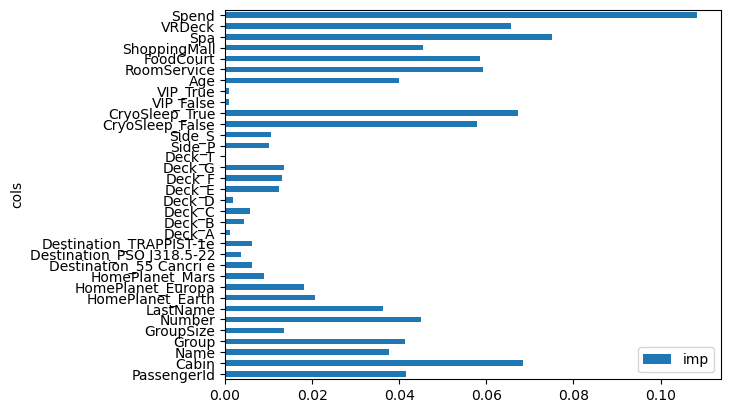

In [56]:
pd.DataFrame(dict(cols=trn_xs.columns, imp=rf_model.feature_importances_)).plot('cols', 'imp', 'barh');

# Create Submission File

I uploaded the submission file and compared it to the test file to make sure it had the same number of rows and that the the Passengerid seemed the same. 

First I'm converting the test dataset categorical data into their continuous values. Then I'm using the function I used earlier to classify all the current columns in the test dataset as independent variables. 

I'm creating the new Transported column in the test dataset as the dependent variable and running the random forest prediction model against the test data. 

I need to rename the PassengerId column into a PassCode column so I can next work to match the coded continuous data back to its original categorical data. 

I need to create a PassengerID categorical data column in the test dataset to match what is in the submit dataset. So where the PassIDCode column from the test_passid dataframe I created earlier matches the PassCode column in the test dataframe, then th PassengerId column in the test dataframe will be filled with the PassengerId value from this earlier test_passid dataframe. Otherwise a NaN value will be created.  

I'm just moving the PassengerId to the front of the datafram here. 

Here I'm converting the Transported column back into the True/False boolean values that will be needed for submission. 

In [57]:
submit = pd.read_csv('sample_submission.csv')
test[test_cat] = test[test_cat].apply(lambda x: x.cat.codes)
test_xs,_ = xs_y(test)
test['Transported'] = rf_model.predict(test_xs)
test.rename(columns={'PassengerId': 'PassCode'}, inplace=True)
test['PassengerId'] = np.where(test_passid['PassIdCode'] == test['PassCode'], test_passid['PassengerId'], 'NaN')
col = test.pop('PassengerId')
test.insert(0, col.name, col)
test['Transported'] = np.where(test['Transported'] == 1, 'True', 'False')

This creates the actual submission file with this initial benchmark random forest model. 

In [58]:
submit_benchmark = test[['PassengerId', 'Transported']]

In [59]:
submit_benchmark.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True


In [60]:
submit_benchmark.to_csv('submit_rf_onehotencode25%.csv', index=False)

The one hot encoding created a submission score of 0.8009, which was lower than not using one hot encoding.

I then increased the validation split back up to 25% and the submission score increased to 0.80173.